In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u

# Pulling the Unresolved Binaries from O'Brien (Table A4)

In [2]:
query = """
SELECT
    gs.source_id,                
    gs.ra,                      
    gs.dec,                     
    gs.parallax,               
    gs.phot_g_mean_mag,  -- absolute
    gs.phot_g_mean_flux, -- apparent   
    gs.phot_bp_mean_mag,  -- absolute
    gs.phot_bp_mean_flux, -- apparent   
    gs.phot_rp_mean_mag,  -- absolute
    gs.phot_rp_mean_flux, -- apparent     
    ap.classprob_dsc_combmod_whitedwarf, 
    ap.classprob_dsc_combmod_binarystar,
    ap.teff_gspphot,
    ap.lum_flame,
    ap.radius_flame,
    ap.mass_flame
FROM
    gaiadr3.gaia_source AS gs   
LEFT JOIN
    gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE
    gs.source_id IN (
        1355264565043431040, 
        3223516063958808064,
        1005873614080407296,
        2185710338703934976,
        4788741548375134336,
        6431977687725247104,
        3729017810434416128,
        1548104507825815296,
        1550299304833675392,
        4478524169500496000,
        2643862402903084544,
        3845263368043086080,
        759601941671398272,
        3000597125173673088
    )
"""


In [3]:
job = Gaia.launch_job(query)
results = job.get_results()

# Galactocentric coordinates

In [4]:
# Turning the string into integers
parallax = results['parallax']
parallax = np.array(parallax)

ra = results['ra']
ra = np.array(ra)

dec = results['dec']
dec = np.array(dec)

#using parallax for postion 
arcsecond = parallax/1000
distance = abs(1/arcsecond)
coords = SkyCoord(ra*u.deg, dec*u.deg, distance*u.pc , frame='icrs')
galactic = coords.transform_to(Galactic)

#gives postions 
X = (galactic.cartesian.x)/u.pc
Y = (galactic.cartesian.y)/u.pc
Z = (galactic.cartesian.z)/u.pc

In [5]:
# Create a dictionary with the results and the boundary parameters
data = {
    'source_id' : results['SOURCE_ID'],
    'ra' : results['ra'],
    'dec' : results['dec'],
    'parallax' : results['parallax'],
    'G_mag' : results['phot_g_mean_mag'],
    'g_flux' : results['phot_g_mean_flux'],     # [e/s]
    'BP_mag' : results['phot_bp_mean_mag'],
    'bp_flux' : results['phot_bp_mean_flux'],     # [e/s]
    'RP_mag' : results['phot_rp_mean_mag'],
    'rp_flux' : results['phot_rp_mean_flux'],     # [e/s]
    'WD_prob' : results['classprob_dsc_combmod_whitedwarf'],
    'Binary_prob' : results['classprob_dsc_combmod_binarystar'],
    'T_eff' : results['teff_gspphot'],
    'lum_flame' : results['lum_flame'],
    'radius_flame' : results['radius_flame'],
    'mass_flame' : results['mass_flame'],
    'X' : X,
    'Y' : Y,
    'Z' : Z 
}
df = pd.DataFrame(data)

Text(0, 0.5, 'Y axis (pc)')

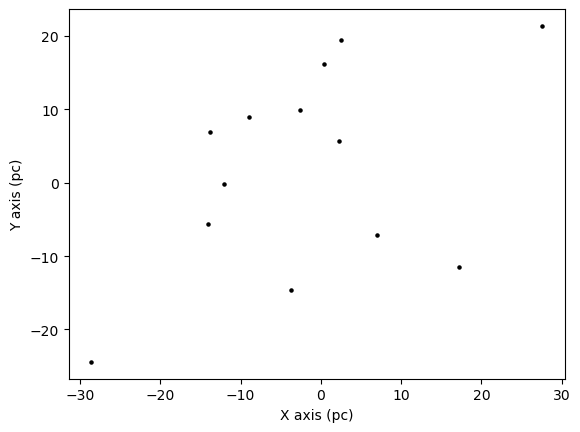

In [6]:
plt.scatter(df['X'], df['Y'], c='k', s=5)
plt.xlabel('X axis (pc)')
plt.ylabel('Y axis (pc)')

# Exposure Times

In [7]:
# when the bands get saturated 
Sat_lim_UVB = 41300     #e
Sat_lim_VIS = 41900     #e
Sat_lim_NIR = 103000    #e
# We decided to go with a SNR of 500 
SNR = 500 

In [8]:
# Testing the math
e_count = SNR**2

bp = df['bp_flux'][0] 
g = df['g_flux'][0]
rp = df['rp_flux'][0]

# min exposure time per band 
min_time_uvb = e_count / bp     #[sec]
min_time_vis = e_count / g      #[sec]
min_time_nir = e_count / rp     #[sec]

# Time it takes for the filter to become saturated
S_time_uvb = Sat_lim_UVB / bp          #[sec]
S_time_vis = Sat_lim_VIS / g            #[sec]
S_time_nir = Sat_lim_NIR / rp          #[sec]
    
# Get the whole number of exposures to prevent saturation, then add 1
Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

# Time for each exposure, based on what is smaller, saturation time or the min time 
Time_per_uvb = min_time_uvb / Num_exp_uvb
Time_per_vis = min_time_vis / Num_exp_vis
Time_per_nir = min_time_nir / Num_exp_nir

print('UVB:', Num_exp_uvb, Time_per_uvb, (Num_exp_uvb * Time_per_uvb))
print('VIS:', Num_exp_vis, Time_per_vis, (Num_exp_vis * Time_per_vis))
print('NIR:', Num_exp_nir, Time_per_nir, (Num_exp_nir * Time_per_nir))

### Cool it works lets make it a function to automate over all the candidates & append the values 

UVB: 7 7.175970980491761 50.23179686344233
VIS: 6 1.5836227459222982 9.50173647553379
NIR: 3 2.4737976908179387 7.4213930724538155


In [9]:
# SNR, next 3 are the flux for each source, next 3 are the saturation constants
def min_exp(SNR, bp, g, rp, S_bp, S_g, S_rp):
    # SNR = N**(1/2), therefore we need an electron count of 
    e_count = SNR**2

    # min exposure time per band 
    min_time_uvb = e_count / bp     #[sec]
    min_time_vis = e_count / g      #[sec]
    min_time_nir = e_count / rp     #[sec]

    # Time it takes for the filter to become saturated
    S_time_uvb = S_bp / bp          #[sec]
    S_time_vis = S_g / g            #[sec]
    S_time_nir = S_rp / rp          #[sec]
    
    # Get the whole number of exposures to prevent saturation, then add 1
    Num_exp_uvb = int(min_time_uvb // S_time_uvb ) + 1
    Num_exp_vis = int(min_time_vis // S_time_vis ) + 1
    Num_exp_nir = int(min_time_nir // S_time_nir ) + 1

    # Time for each exposure 
    Time_per_uvb = min_time_uvb / Num_exp_uvb
    Time_per_vis = min_time_vis / Num_exp_vis
    Time_per_nir = min_time_nir / Num_exp_nir

    return  {
        'Num_exp_uvb': Num_exp_uvb,
        'Time_per_uvb': Time_per_uvb,
        'Total_time_uvb': Num_exp_uvb * Time_per_uvb,

        'Num_exp_vis': Num_exp_vis,
        'Time_per_vis': Time_per_vis,
        'Total_time_vis': Num_exp_vis * Time_per_vis,

        'Num_exp_nir': Num_exp_nir,
        'Time_per_nir': Time_per_nir,
        'Total_time_nir': Num_exp_nir * Time_per_nir,
    }

In [10]:
def times(row):
    return min_exp(
        SNR=SNR,
        bp=row['bp_flux'],
        g=row['g_flux'],
        rp=row['rp_flux'],
        S_bp=Sat_lim_UVB,
        S_g=Sat_lim_VIS,
        S_rp=Sat_lim_NIR
    )

exp_results = df.apply(times, axis=1)

exp_df = pd.DataFrame(exp_results.tolist())
df = pd.concat([df, exp_df], axis=1)

In [11]:
df

,source_id,ra,dec,parallax,G_mag,g_flux,BP_mag,bp_flux,RP_mag,rp_flux,...,Z,Num_exp_uvb,Time_per_uvb,Total_time_uvb,Num_exp_vis,Time_per_vis,Total_time_vis,Num_exp_nir,Time_per_nir,Total_time_nir
0,759601941671398272,173.926345,35.573110,25.912642,14.637024,2.631098e+04,16.096140,4.976927e+03,13.429259,3.368640e+04,...,36.661392,7,7.175971,50.231797,6,1.583623,9.501736,3,2.473798,7.421393
1,1005873614080407296,91.375153,60.819401,61.426245,12.296865,2.270913e+05,13.905001,3.744695e+04,11.030190,3.069605e+05,...,5.074688,7,0.953730,6.676110,6,0.183480,1.100879,3,0.271479,0.814437
2,1355264565043431040,257.383472,43.680106,131.599609,10.453175,1.240729e+06,12.083977,2.003670e+05,9.206717,1.646157e+06,...,4.496746,7,0.178244,1.247710,6,0.033582,0.201494,3,0.050623,0.151869
3,1548104507825815296,183.933081,52.516438,34.949439,12.570832,1.764469e+05,13.398948,5.968124e+04,11.590655,1.831877e+05,...,25.661764,7,0.598417,4.188921,6,0.236143,1.416857,3,0.454907,1.364721
4,1550299304833675392,201.720680,45.545521,32.772760,11.962571,3.089715e+05,13.127986,7.659892e+04,10.871877,3.551465e+05,...,28.723288,7,0.466251,3.263754,6,0.134856,0.809136,3,0.234645,0.703935
5,2185710338703934976,301.250286,54.430214,60.295787,11.170794,6.406623e+05,12.231574,1.748989e+05,10.149961,6.905157e+05,...,3.442492,7,0.204200,1.429397,6,0.065037,0.390221,3,0.120683,0.362048
6,2643862402903084544,352.376276,-1.036004,27.534764,6.736706,3.804208e+07,7.043769,2.079262e+07,6.258983,2.486367e+07,...,-30.573229,7,0.001718,0.012023,6,0.001095,0.006572,3,0.003352,0.010055
7,3000597125173673088,93.933723,-12.791415,25.845194,18.125025,1.059100e+03,19.234697,2.764001e+02,16.963272,1.299719e+03,...,-9.116379,7,129.212266,904.485862,6,39.341580,236.049478,3,64.116415,192.349244
8,3223516063958808064,83.435637,1.944719,63.359707,10.379727,1.327565e+06,11.680991,2.904159e+05,9.250252,1.581457e+06,...,-4.424331,7,0.122976,0.860835,6,0.031386,0.188315,3,0.052694,0.158082
9,3729017810434416128,197.212977,5.204217,37.867721,6.628449,4.203073e+07,6.955802,2.254738e+07,6.129251,2.801933e+07,...,24.430369,7,0.001584,0.011088,6,0.000991,0.005948,3,0.002974,0.008922


# Looking at the RA & DEC 

#### Can we group the stars to make observing 'cheaper'

Text(0, 0.5, 'dec (deg)')

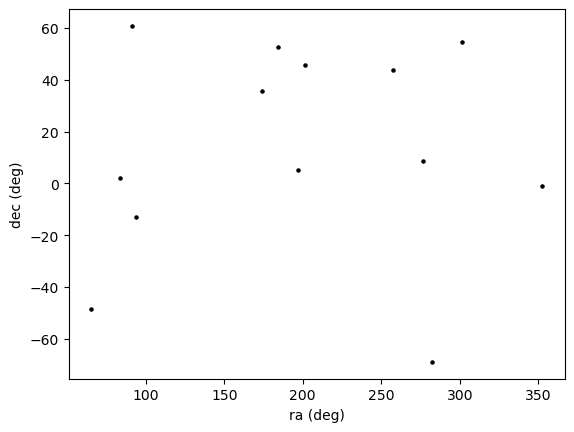

In [12]:
plt.scatter(df['ra'], df['dec'], c='k', s=5)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

# Using Astroplan

In [13]:
#pip install astroplan